In [1]:
import pandas as pd
import numpy as np
import json
import csv
import pickle

In [2]:
# Read the data
with open('../../data/parameters/demand_matrix.pkl','rb') as f:
    d = pickle.load(f)

In [6]:
np.max(d)

24.0

In [4]:
# Average demand per day
d2 = np.zeros((d.shape[0],d.shape[1],d.shape[2]//30))
for i in range(30):
    d2 = d2 + d[:,:,i*24:(i+1)*24]/30
d2 = np.ceil(d2)

In [5]:
sum(d2[1,:,:])

array([ 18.,  22.,   7.,   3.,   0.,   9.,  23.,  42.,  46.,  47.,  40.,
        50.,  60.,  68.,  51.,  59.,  79.,  83., 100.,  73.,  64.,  44.,
        64.,  37.])

In [6]:
nb_stations,_,hours = d2.shape
count = 0
for j in range(nb_stations):
    for t in range(24):
        count += d2[400,j,t]
print(count)


130.0


In [7]:
s = []
nb_stations,_,hours = d2.shape
for i in range(nb_stations):
    bikes = 0
    for j in range(nb_stations):
        for t in range(hours):
            bikes += d2[j,i,t] + d2[i,j,t]
    s.append(bikes)


AttributeError: 'tuple' object has no attribute 'show'

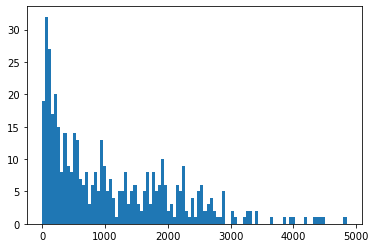

In [9]:
# Histogram of the number of bikes per station
import matplotlib.pyplot as plt
plt.hist(s, bins=100).show()

In [ ]:
with open("./station_information.json") as f:
    data = json.load(f)

stations = data['data']['stations']

with open('./station_information.csv', 'w') as f:
    writer = csv.writer(f)
    count=0
    for station in stations:
        if count==0:
            writer.writerow(station.keys())
        count+=1
        writer.writerow(station.values())
    

: 

In [ ]:
with open("./station_status.json") as f:
    data = json.load(f)

stations = data['data']['stations']

with open('./station_status.csv', 'w') as f:
    writer = csv.writer(f)
    count=0
    for station in stations:
        if count==0:
            writer.writerow(station.keys())
        count+=1
        writer.writerow(station.values())

: 

In [3]:
trips = pd.read_csv('../../data/trips/202210-bluebikes-tripdata.csv')

n_stations = len(trips['start station id'].unique())

stations_match = dict(zip(trips['start station id'].unique(),range(n_stations)))

X = np.zeros((n_stations, 1440*30))

In [7]:
stations_info=pd.read_csv('../../data/stations/station_information.csv')
#stations_info

In [8]:
## Other version of stations_match with all the stations from the stations_information file
n_stations2=len(stations_info['station_id'].unique())
stations_match2 = dict(zip(stations_info['station_id'].unique(),range(n_stations2)))
len(stations_match2)

449

In [9]:
from pandas import to_datetime


trips.starttime = trips.starttime.apply(to_datetime)
trips.stoptime = trips.stoptime.apply(to_datetime)

trips['start_hour'] = trips.starttime.apply(lambda x: x.hour)
trips['start_minute'] = trips.starttime.apply(lambda x: x.minute)
trips['start_day'] = trips.starttime.apply(lambda x: x.day)

trips['stop_hour'] = trips.stoptime.apply(lambda x: x.hour)
trips['stop_minute'] = trips.stoptime.apply(lambda x: x.minute)
trips['stop_day'] = trips.stoptime.apply(lambda x: x.day)



In [ ]:
bikes_taken = trips.groupby(['start_day', 'start_hour', 'start_minute', 'start station id']).size().reset_index(name='counts')
bikes_returned = trips.groupby(['stop_day', 'stop_hour', 'stop_minute', 'end station id']).size().reset_index(name='counts')

: 

In [ ]:
for i in range(len(bikes_taken)):
    X[stations_match[bikes_taken.iloc[i,3]], (bikes_taken.iloc[i,0]-1)*1440 + bikes_taken.iloc[i,1]*60 + bikes_taken.iloc[i,2]] -= bikes_taken.iloc[i,4]
for i in range(len(bikes_returned)):
    X[stations_match[bikes_returned.iloc[i,3]], (bikes_returned.iloc[i,0]-1)*1440 + bikes_returned.iloc[i,1]*60 + bikes_returned.iloc[i,2]] += bikes_returned.iloc[i,4]

: 

In [ ]:
min(X[0])

: 

# Input data construction

In [ ]:
capacity_df = stations_info[['station_id','capacity']] 
# Data frame with columns "station_id" and "capacity"

: 

In [ ]:
# Capacity Matrix C -> index = stations_match2['station_id']
C=capacity_df['capacity'].to_numpy()
#C

: 

In [ ]:
# Distance matrix D -> index = stations_match2['station_id']
D=np.zeros((n_stations2,n_stations2))
for i in range(n_stations2):
    for j in range(n_stations2):
        D[i,j]=np.sqrt((stations_info['lon'][i]-stations_info['lon'][j])**2+(stations_info['lat'][i]-stations_info['lat'][j])**2)
#D

: 

In [ ]:
# Feasibility matrix X
threshold=np.quantile(D,0.1)
# let's build a matrix X with the same shape as D that is equal to 1 when D is inferior to the threshold and 0 otherwise
X=np.zeros((n_stations2,n_stations2))
for i in range(n_stations2):
    for j in range(n_stations2):
        if D[i,j]<threshold:
            X[i,j]=1

: 

In [ ]:
# Let's count the non-zero elements of X
np.count_nonzero(X)

: 

In [ ]:
# let's count the non-zero elements in a row of X
np.count_nonzero(X[0])

: 